# Teste Técnico Data Science Congnitivo.AI

## Introdução

Nosso dataset é uma extração de dados do Airbnb Rio de Janeiro, conforme enviado por e-mail no link do desafio.

Temos como objetivo criar um modelo capaz de prever o preço da estadia (feature 'price').


In [1]:
# Importação de pacotes
import gzip
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import math
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

## Coleta de Dados

In [2]:
# Dados Listings
listings = pd.read_csv('listings.csv.gz', compression='gzip')
listings.head(3)

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,17878,https://www.airbnb.com/rooms/17878,20210222161029,2021-02-23,"Very Nice 2Br in Copacabana w. balcony, fast WiFi",Discounts for long term stays. <br />- Large b...,This is the one of the bests spots in Rio. Bec...,https://a0.muscache.com/pictures/65320518/3069...,68997,https://www.airbnb.com/users/show/68997,Matthias,2010-01-08,"Rio de Janeiro, State of Rio de Janeiro, Brazil",I am a journalist/writer. Lived for 15 years...,within an hour,100%,100%,t,https://a0.muscache.com/im/pictures/user/67b13...,https://a0.muscache.com/im/pictures/user/67b13...,Copacabana,2.0,2.0,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,t,"Rio de Janeiro, Brazil",Copacabana,NaN,-22.96592,-43.17896,Entire condominium,Entire home/apt,5,NaN,1 bath,2.0,2.0,"[""Air conditioning"", ""Essentials"", ""Luggage dr...",$221.00,5,180,5.0,5.0,1125.0,1125.0,5.0,1125.0,NaN,t,0,8,38,304,2021-02-23,260,12,2,2010-07-15,2021-02-08,94.0,9.0,9.0,10.0,10.0,10.0,9.0,NaN,t,1,1,0,0,2.01
1,24480,https://www.airbnb.com/rooms/24480,20210222161029,2021-02-23,Nice and cozy near Ipanema Beach,My studio is located in the best of Ipanema. ...,"The beach, the lagoon, Ipanema is a great loca...",https://a0.muscache.com/pictures/11955612/b28e...,99249,https://www.airbnb.com/users/show/99249,Goya,2010-03-26,"Rio de Janeiro, Rio de Janeiro, Brazil",Welcome to Rio!\r\nI am a filmmaker and a tea...,within a few hours,100%,NaN,f,https://a0.muscache.com/im/pictures/user/6b404...,https://a0.muscache.com/im/pictures/user/6b404...,Ipanema,0.0,0.0,"['email', 'phone', 'facebook', 'reviews', 'jum...",t,t,"Rio de Janeiro, Brazil",Ipanema,NaN,-22.98570,-43.20193,Entire apartment,Entire home/apt,2,NaN,1 bath,1.0,1.0,"[""Extra pillows and blankets"", ""Air conditioni...",$307.00,3,90,3.0,3.0,90.0,90.0,3.0,90.0,NaN,t,0,0,0,10,2021-02-23,85,0,0,2010-09-26,2018-02-14,95.0,10.0,10.0,10.0,10.0,10.0,9.0,NaN,f,1,1,0,0,0.67
2,25026,https://www.airbnb.com/rooms/25026,20210222161029,2021-02-23,Beautiful Modern Decorated Studio in Copa,"Our apartment is a little gem, everyone loves ...",Copacabana is a lively neighborhood and the ap...,https://a0.muscache.com/pictures/3003965/68ebb...,3746246,https://www.airbnb.com/users/show/3746246,Ghizlane,2012-10-03,"Rio de Janeiro, Rio de Janeiro, Brazil","French girl ""lost in Brazilian translation"" si...",within a few hours,97%,78%,f,https://a0.muscache.com/im/pictures/user/fffed...,https://a0.muscache.com/im/pictures/user/fffed...,Ipanema,11.0,11.0,"['phone', 'reviews', 'jumio', 'offline_governm...",t,f,"Rio de Janeiro, Brazil",Copacabana,NaN,-22.97712,-43.19045,Entire apartment,Entire home/apt,2,NaN,1 bath,1.0,2.0,"[""Elevator"", ""Dedicated workspace"", ""Kitche

In [3]:
# Formato dos dados
listings.shape

(26615, 74)

In [4]:
# Dados Calendar
calendar = pd.read_csv('calendar.csv.gz', compression='gzip')
calendar.head(3)

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,45766287,2021-02-23,f,$150.00,$150.00,2.0,1125.0
1,45764740,2021-02-24,f,$100.00,$100.00,1.0,4.0
2,45764740,2021-02-25,t,$100.00,$100.00,1.0,4.0


In [5]:
# Formato dos dados
calendar.shape

(9685126, 7)

In [6]:
# Trazendo amostra dos dados para o estudo
calendar = calendar.sample(n= 2000000, random_state=1)
len(calendar)

2000000

In [7]:
calendar.head()

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
2527774,12778853,2021-06-18,t,$149.00,$149.00,2.0,15.0
9670176,48227945,2022-02-08,t,$636.00,$636.00,2.0,90.0
5909729,32590121,2021-07-19,f,$309.00,$294.00,2.0,545.0
745339,2539099,2021-12-12,f,$270.00,$270.00,1.0,1125.0
5826052,32224114,2021-06-20,f,"$1,800.00","$1,800.00",6.0,1125.0


## Separação das variáveis de interesse

Vamos utilizar 2 datasets para a criação do modelo:

- calendar.csv com informações das listagens: preço e data disponível
- listings.csv com informações resumidas sobre as acomodações

In [8]:
# Selecionando as colunas de interesse do dataset listings
listings_columns = listings[['id'  
                             ## Reviews do Hotel ##
                            ,'review_scores_rating'       
                            ,'review_scores_accuracy'
                            ,'review_scores_cleanliness'  
                            ,'review_scores_checkin'
                            ,'review_scores_communication'
                            ,'review_scores_location' 
                            ,'review_scores_value'
                            ## Informações da acomodação ##
                            ,'room_type'
                            ,'accommodates'
                            ,'bedrooms'
                            ,'beds'
                            ## Informações do Host ##
                            ,'host_since'
                            ,'host_response_rate'
                            ,'host_acceptance_rate'
                            ,'host_is_superhost'
                            ]]

In [9]:
listings_columns.head()

,id,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,room_type,accommodates,bedrooms,beds,host_since,host_response_rate,host_acceptance_rate,host_is_superhost
0,17878,94.0,9.0,9.0,10.0,10.0,10.0,9.0,Entire home/apt,5,2.0,2.0,2010-01-08,100%,100%,t
1,24480,95.0,10.0,10.0,10.0,10.0,10.0,9.0,Entire home/apt,2,1.0,1.0,2010-03-26,100%,NaN,f
2,25026,94.0,9.0,9.0,9.0,10.0,10.0,9.0,Entire home/apt,2,1.0,2.0,2012-10-03,97%,78%,f
3,35636,94.0,10.0,9.0,10.0,10.0,10.0,9.0,Entire home/apt,2,1.0,1.0,2010-06-27,NaN,100%,t
4,35764,98.0,10.0,10.0,10.0,10.0,10.0,10.0,Entire home/apt,2,1.0,1.0,2010-06-27,100%,94%,t


In [10]:
# Selecionando as colunas de interesse do dataset calendar
calendar['mes'] = pd.to_datetime(calendar['date']).dt.month
calendar['ano'] = pd.to_datetime(calendar['date']).dt.year

In [11]:
calendar.head()

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights,mes,ano
2527774,12778853,2021-06-18,t,$149.00,$149.00,2.0,15.0,6,2021
9670176,48227945,2022-02-08,t,$636.00,$636.00,2.0,90.0,2,2022
5909729,32590121,2021-07-19,f,$309.00,$294.00,2.0,545.0,7,2021
745339,2539099,2021-12-12,f,$270.00,$270.00,1.0,1125.0,12,2021
5826052,32224114,2021-06-20,f,"$1,800.00","$1,800.00",6.0,1125.0,6,2021


In [12]:
# Verificando se não temos id's duplicados no dataset listings
len(listings) == len(listings['id'].drop_duplicates())

True

In [13]:
# Realizando Merge dos dados
df = calendar.merge(listings_columns, left_on = 'listing_id', right_on = 'id')
df.shape

(2000000, 25)

In [14]:
# Verificando se não duplicamos os dados após o Merge
calendar.shape[0] == df.shape[0]

True

In [15]:
# Eliminando colunas que não vamos utilizar
del(df['listing_id'])
del(df['id'])
del(df['date'])
del(df['ano'])
del(df['adjusted_price'])
del(df['host_since'])
del(df['available'])

In [16]:
# Informações sobre os dados
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000000 entries, 0 to 1999999
Data columns (total 18 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   price                        object 
 1   minimum_nights               float64
 2   maximum_nights               float64
 3   mes                          int64  
 4   review_scores_rating         float64
 5   review_scores_accuracy       float64
 6   review_scores_cleanliness    float64
 7   review_scores_checkin        float64
 8   review_scores_communication  float64
 9   review_scores_location       float64
 10  review_scores_value          float64
 11  room_type                    object 
 12  accommodates                 int64  
 13  bedrooms                     float64
 14  beds                         float64
 15  host_response_rate           object 
 16  host_acceptance_rate         object 
 17  host_is_superhost            object 
dtypes: float64(11), int64(2), object(5)
memory

## Valores Nulos

In [17]:
# Valores nulos por coluna
df.isnull().sum()

price                              37
minimum_nights                   1227
maximum_nights                   1227
mes                                 0
review_scores_rating           788008
review_scores_accuracy         789112
review_scores_cleanliness      788890
review_scores_checkin          788969
review_scores_communication    788620
review_scores_location         788928
review_scores_value            788780
room_type                           0
accommodates                        0
bedrooms                       130830
beds                            18995
host_response_rate             601450
host_acceptance_rate           716361
host_is_superhost                1779
dtype: int64

In [18]:
comp_inicial = len(df)
comp_inicial

2000000

In [19]:
# Eliminando onde a coluna Price é nulo
df.dropna(subset=['price'],inplace=True)

# Percentual de linhas que eliminamos
len(df)

1999963

In [20]:
# Substituindo nulos da coluna review pela média de cada coluna
reviews = [ 'review_scores_rating'
           ,'review_scores_accuracy'
           ,'review_scores_cleanliness'
           ,'review_scores_checkin'
           ,'review_scores_communication'
           ,'review_scores_location'
           ,'review_scores_value']

for i in reviews:
    df[i].fillna(df[i].mean(),inplace=True)

In [21]:
# Substituindo nulos das informações da acomodação pela moda das colunas
room = ['minimum_nights', 'maximum_nights', 'bedrooms', 'beds', 
        'host_is_superhost', 'host_response_rate','host_acceptance_rate']
for i in room:
    df[i].fillna(df[i].mode()[0],inplace=True)

In [22]:
# Finalmente sem nulos
df.isnull().sum()

price                          0
minimum_nights                 0
maximum_nights                 0
mes                            0
review_scores_rating           0
review_scores_accuracy         0
review_scores_cleanliness      0
review_scores_checkin          0
review_scores_communication    0
review_scores_location         0
review_scores_value            0
room_type                      0
accommodates                   0
bedrooms                       0
beds                           0
host_response_rate             0
host_acceptance_rate           0
host_is_superhost              0
dtype: int64

In [23]:
df.head()

,price,minimum_nights,maximum_nights,mes,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,room_type,accommodates,bedrooms,beds,host_response_rate,host_acceptance_rate,host_is_superhost
0,$149.00,2.0,15.0,6,95.0,10.0,10.0,10.0,10.0,9.0,10.0,Entire home/apt,2,1.0,1.0,100%,100%,f
1,$149.00,2.0,15.0,3,95.0,10.0,10.0,10.0,10.0,9.0,10.0,Entire home/apt,2,1.0,1.0,100%,100%,f
2,$149.00,2.0,15.0,9,95.0,10.0,10.0,10.0,10.0,9.0,10.0,Entire home/apt,2,1.0,1.0,100%,100%,f
3,$149.00,2.0,15.0,11,95.0,10.0,10.0,10.0,10.0,9.0,10.0,Entire home/apt,2,1.0,1.0,100%,100%,f
4,$149.00,2.0,15.0,7,95.0,10.0,10.0,10.0,10.0,9.0,10.0,Entire home/apt,2,1.0,1.0,100%,100%,f


In [24]:
# Convertendo a coluna price para Float
df['price'] = df['price'].str.lstrip('$').str.replace(',',"").astype('float')

In [25]:
# Convertendo a coluna host_response_rate para inteiro
df['host_response_rate'] = df['host_response_rate'].str.rstrip('%').astype('int')

In [26]:
# Convertendo a coluna host_acceptance_rate para inteiro
df['host_acceptance_rate'] = df['host_acceptance_rate'].str.rstrip('%').astype('int')

In [27]:
# Vamos transformar essa variável categórica em número
superhost = {'f':0, 't':1}
df['host_is_superhost'] = df['host_is_superhost'].map(superhost)

In [28]:
# Tipo dos dados após os ajustes
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1999963 entries, 0 to 1999999
Data columns (total 18 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   price                        float64
 1   minimum_nights               float64
 2   maximum_nights               float64
 3   mes                          int64  
 4   review_scores_rating         float64
 5   review_scores_accuracy       float64
 6   review_scores_cleanliness    float64
 7   review_scores_checkin        float64
 8   review_scores_communication  float64
 9   review_scores_location       float64
 10  review_scores_value          float64
 11  room_type                    object 
 12  accommodates                 int64  
 13  bedrooms                     float64
 14  beds                         float64
 15  host_response_rate           int32  
 16  host_acceptance_rate         int32  
 17  host_is_superhost            int64  
dtypes: float64(12), int32(2), int64(3), object

In [29]:
# Criando variáveis Dummy para a coluna de tipo de quarto
set(df['room_type'])

{'Entire home/apt', 'Hotel room', 'Private room', 'Shared room'}

In [30]:
# Realizando o Merge dos dados
df01 = pd.concat([df,pd.get_dummies(df['room_type'], prefix='rt')], axis = 1)

In [31]:
# Verificando se não duplicamos nada após o Merge
len(df) ==  len(df01)

True

In [32]:
del(df01['room_type'])

In [33]:
df01.head()

,price,minimum_nights,maximum_nights,mes,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,accommodates,bedrooms,beds,host_response_rate,host_acceptance_rate,host_is_superhost,rt_Entire home/apt,rt_Hotel room,rt_Private room,rt_Shared room
0,149.0,2.0,15.0,6,95.0,10.0,10.0,10.0,10.0,9.0,10.0,2,1.0,1.0,100,100,0,1,0,0,0
1,149.0,2.0,15.0,3,95.0,10.0,10.0,10.0,10.0,9.0,10.0,2,1.0,1.0,100,100,0,1,0,0,0
2,149.0,2.0,15.0,9,95.0,10.0,10.0,10.0,10.0,9.0,10.0,2,1.0,1.0,100,100,0,1,0,0,0
3,149.0,2.0,15.0,11,95.0,10.0,10.0,10.0,10.0,9.0,10.0,2,1.0,1.0,100,100,0,1,0,0,0
4,149.0,2.0,15.0,7,95.0,10.0,10.0,10.0,10.0,9.0,10.0,2,1.0,1.0,100,100,0,1,0,0,0


# Análise Exploratória

### Análise da variável Mês

In [34]:
# Preço Médio por mês
pc_mes = df01[['price','mes']].groupby('mes').mean().reset_index()
pc_mes

,mes,price
0,1,1018.286803
1,2,774.724288
2,3,752.755579
3,4,804.331947
4,5,739.267109
5,6,803.717798
6,7,799.736960
7,8,1027.913669
8,9,1010.421849
9,10,903.528959


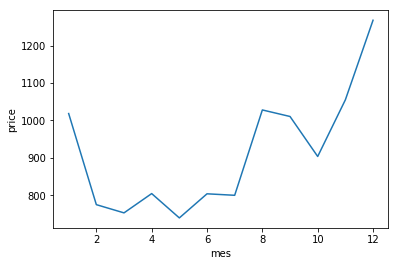

In [35]:
# Gráfico de linhas
ax = sns.lineplot(x = 'mes', y = 'price', data=pc_mes)

In [36]:
# Separando em Alta Temporada e Baixa Temporada
pc_mes['alta_temporada']  = np.where(pc_mes['price'] >= 1000, 1, 0)
pc_mes['baixa_temporada'] = np.where(pc_mes['price'] < 1000, 1, 0)
del(pc_mes['price'])

In [37]:
# Já criamos as variáveis booleanas para a etapa de modelagem preditiva
pc_mes

,mes,alta_temporada,baixa_temporada
0,1,1,0
1,2,0,1
2,3,0,1
3,4,0,1
4,5,0,1
5,6,0,1
6,7,0,1
7,8,1,0
8,9,1,0
9,10,0,1


In [38]:
# Realizando Merge dos dados no dataframe principal
df01 = df01.merge(pc_mes, left_on = 'mes', right_on = 'mes')
df01.shape

(1999963, 23)

In [39]:
# Deletando a coluna de mês
del(df01['mes'])

df01.head()

,price,minimum_nights,maximum_nights,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,accommodates,bedrooms,beds,host_response_rate,host_acceptance_rate,host_is_superhost,rt_Entire home/apt,rt_Hotel room,rt_Private room,rt_Shared room,alta_temporada,baixa_temporada
0,149.0,2.0,15.0,95.0,10.0,10.0,10.0,10.0,9.0,10.0,2,1.0,1.0,100,100,0,1,0,0,0,0,1
1,149.0,2.0,15.0,95.0,10.0,10.0,10.0,10.0,9.0,10.0,2,1.0,1.0,100,100,0,1,0,0,0,0,1
2,149.0,2.0,15.0,95.0,10.0,10.0,10.0,10.0,9.0,10.0,2,1.0,1.0,100,100,0,1,0,0,0,0,1
3,149.0,2.0,15.0,95.0,10.0,10.0,10.0,10.0,9.0,10.0,2,1.0,1.0,100,100,0,1,0,0,0,0,1
4,149.0,2.0,15.0,95.0,10.0,10.0,10.0,10.0,9.0,10.0,2,1.0,1.0,100,100,0,1,0,0,0,0,1


### Distribuição da Variável Preço

In [40]:
df01['price'].describe()

count    1.999963e+06
mean     9.142812e+02
std      9.097347e+03
min      0.000000e+00
25%      1.600000e+02
50%      2.900000e+02
75%      5.500000e+02
max      2.182800e+06
Name: price, dtype: float64

In [41]:
# Eliminando onde o preço = 0
df01 = df01[df01['price'] > 0]

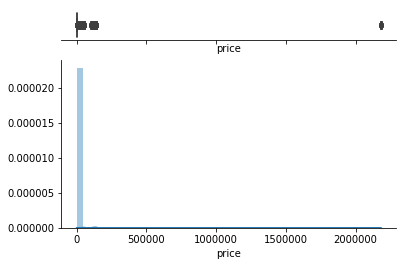

In [42]:
x = df01['price']

f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})

sns.boxplot(x, ax=ax_box)
sns.distplot(x, ax=ax_hist)

ax_box.set(yticks=[])
sns.despine(ax=ax_hist)
sns.despine(ax=ax_box, left=True)

Eliminando Outliers dos Dados

In [43]:
# Método IQR 1,5
first_quartile = df01['price'].describe()['25%']
third_quartile = df01['price'].describe()['75%']

# Interquartile range
iqr = third_quartile - first_quartile

# Remove outliers
df01 = df01[(df01['price'] > (first_quartile - 1.5 * iqr)) &
            (df01['price'] < (third_quartile + 1.5 * iqr))]

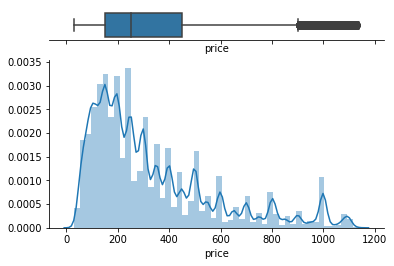

In [44]:
# Distribuição após a eliminação dos Outliers
x = df01['price']

f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})

sns.boxplot(x, ax=ax_box)
sns.distplot(x, ax=ax_hist)

ax_box.set(yticks=[])
sns.despine(ax=ax_hist)
sns.despine(ax=ax_box, left=True)

Assimetria dos dados (Power Transformation)

In [45]:
# Medida de Assimetria
round(df01['price'].skew(),4)

1.2963

In [46]:
# Medida de Assimetria após a Transformação
(df01['price']**(1/2)).skew()

0.6779934301160294

Conseguimos reduzir a assimetria da variável price

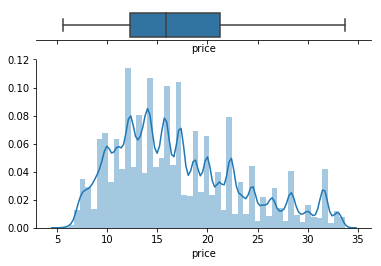

In [48]:
# Distribuição após a Transformação
x = df01['price']**(1/2)

f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})

sns.boxplot(x, ax=ax_box)
sns.distplot(x, ax=ax_hist)

ax_box.set(yticks=[])
sns.despine(ax=ax_hist)
sns.despine(ax=ax_box, left=True)

In [49]:
# Aplicando a Transformação Potência
df01['price'] = df01['price']**(1/2)

## Correlação entre as Variáveis

In [50]:
df01.shape

(1787479, 22)

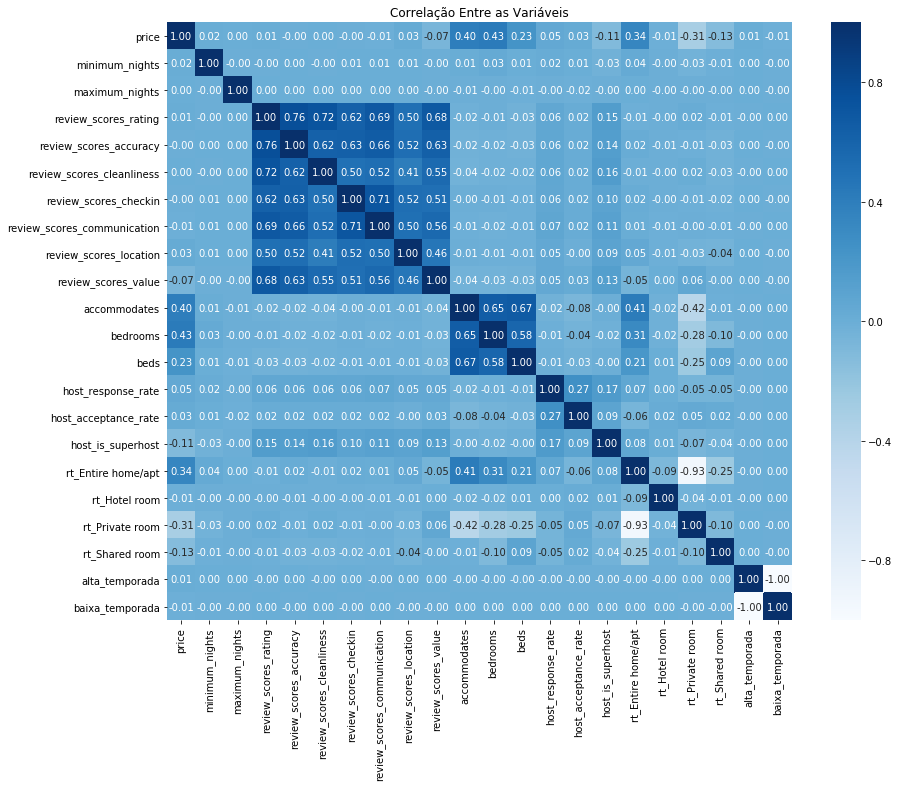

In [51]:
fig = plt.figure(figsize = (14,11))
sns.heatmap(df01.corr(),
            annot = True,
            fmt = '.2f',
            cmap = 'Blues')
plt.title('Correlação Entre as Variáveis')
plt.show()

In [52]:
# Resumo das correlações com a Variável Preço (Ordenado da maior para a menor)
round(df01.corr().iloc[:,0],3).sort_values(ascending = False)

price                          1.000
bedrooms                       0.426
accommodates                   0.399
rt_Entire home/apt             0.344
beds                           0.232
host_response_rate             0.054
host_acceptance_rate           0.031
review_scores_location         0.027
minimum_nights                 0.015
review_scores_rating           0.013
alta_temporada                 0.010
review_scores_cleanliness      0.002
maximum_nights                 0.000
review_scores_checkin         -0.002
review_scores_accuracy        -0.003
review_scores_communication   -0.008
baixa_temporada               -0.010
rt_Hotel room                 -0.014
review_scores_value           -0.070
host_is_superhost             -0.109
rt_Shared room                -0.130
rt_Private room               -0.306
Name: price, dtype: float64

## Seleção de Variáveis com Random Forest Regressor

Vamos descobrir quais variáveis são mais relevantes para o modelo

In [53]:
df01.columns

Index(['price', 'minimum_nights', 'maximum_nights', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value', 'accommodates',
       'bedrooms', 'beds', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'rt_Entire home/apt', 'rt_Hotel room',
       'rt_Private room', 'rt_Shared room', 'alta_temporada',
       'baixa_temporada'],
      dtype='object')

In [54]:
# Definindo variáveis para calcularmos a sua importância
preditoras = [
       'minimum_nights', 'maximum_nights', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value', 'accommodates',
       'bedrooms', 'beds', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'rt_Entire home/apt', 'rt_Hotel room',
       'rt_Private room', 'rt_Shared room', 'alta_temporada',
       'baixa_temporada']

X = df01[preditoras].values
Y = df01['price'].values

X_treino, X_teste, Y_treino, Y_teste = train_test_split(X, Y, random_state = 7)

modelo = RandomForestRegressor(random_state = 42)
modelo.fit(X_treino, Y_treino)

RandomForestRegressor(random_state=42)

In [55]:
importance = pd.Series(data = modelo.feature_importances_, index = df01[preditoras].columns).sort_values(ascending = False)

Text(0.5, 1.0, 'Importância das Variáveis')

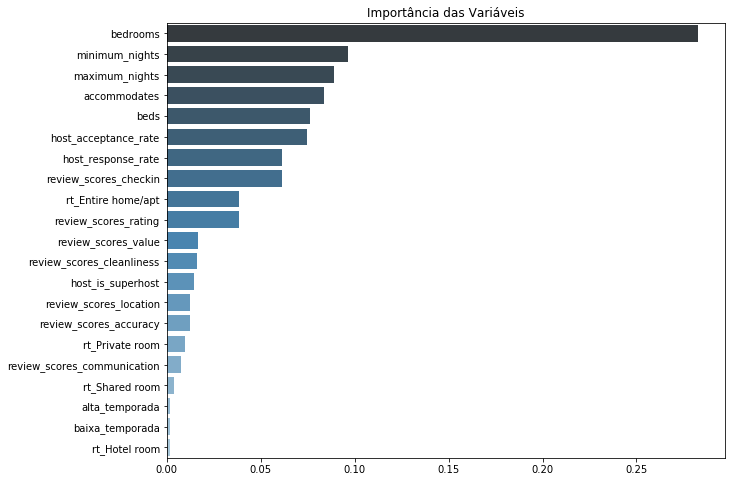

In [56]:
fig = plt.figure(figsize = (10,8))
sns.barplot(x = importance, y = importance.index, orient = 'h', palette = 'Blues_d').set_title('Importância das Variáveis')

## Modelagem Preditiva

In [57]:
importance

bedrooms                       0.282908
minimum_nights                 0.096386
maximum_nights                 0.089030
accommodates                   0.083450
beds                           0.076171
host_acceptance_rate           0.074618
host_response_rate             0.061338
review_scores_checkin          0.061284
rt_Entire home/apt             0.038473
review_scores_rating           0.038175
review_scores_value            0.016779
review_scores_cleanliness      0.016071
host_is_superhost              0.014299
review_scores_location         0.012422
review_scores_accuracy         0.012218
rt_Private room                0.009929
review_scores_communication    0.007731
rt_Shared room                 0.003617
alta_temporada                 0.001834
baixa_temporada                0.001804
rt_Hotel room                  0.001464
dtype: float64

In [58]:
# Definindo as variáveis previstas e preditoras
preditoras = ['bedrooms','minimum_nights','maximum_nights','accommodates','host_acceptance_rate',
              'beds','host_response_rate','review_scores_checkin', 'review_scores_rating',
              'rt_Entire home/apt','review_scores_value','review_scores_cleanliness','host_is_superhost']

X = df01[preditoras].values
Y = df01['price'].values

In [59]:
# Definindo o tamanho do split dos dados para o treinamento
teste_size = 0.30
seed = 7

# Criando os conjuntos de dados de treino e de teste
X_treino, X_teste, Y_treino, Y_teste = train_test_split(X, Y, test_size = teste_size, random_state = seed)

In [60]:
# Criação do modelo
modelo = RandomForestRegressor(n_estimators = 20, max_depth = None, min_samples_split = 2, random_state = 0)

# Treinamento do modelo
modelo.fit(X_treino, Y_treino)

# Previsões
prev = modelo.predict(X_teste)

### Resultados do Modelo

In [61]:
# R2
r2 = round(r2_score(Y_teste, prev),2)
print('R²:', r2) 

R²: 0.85


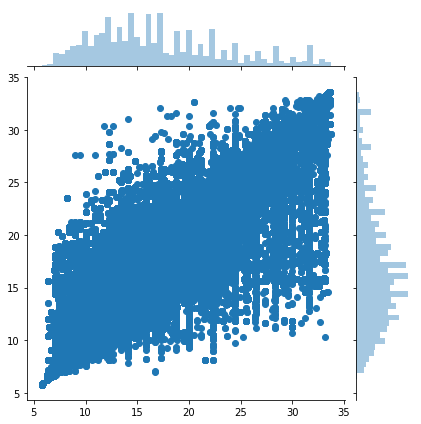

In [62]:
# Scatter plot dos dados de teste vs dados previstos
sns.jointplot(Y_teste, prev)

Text(0.5, 0, 'Erro ($)')

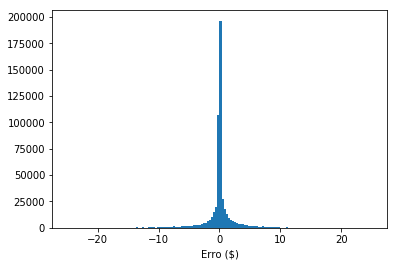

In [63]:
# Histograma do Erro
plt.hist(prev - Y_teste, bins = 150, range = [-25, 25])
plt.xlabel('Erro ($)')

## Conclusão

Após a aplicação de algumas técnicas, como:

- Remoção de Outliers
- Transformação Potência da variável price com o objetivo de deixar mais próxima de uma distribuição normal
- Eliminação de casos onde a variável 'price' era nula ou igual a zero
- Substituição de valores nulso pela média ou moda
- RandomForest para coletarmos a importância de cada variável para explicar a variável price
 
 
 Utilizamos o RandomForestRegressor para construir um modelo de regressão capaz de prever a variável 'price' com um r2 de 0.85.


# Fim